# Module 3: Inverse Planning

In [1]:
using Gen
using Luxor
using Gadfly

## The Problem

Image we are observing an agent interact with the environment.

In this simple world, the agent can move towards an object if he likes it.

However, there may be something making the long

In [2]:
struct Scene 
    object::Symbol
    light_present::Bool
end

In [42]:
@gen function generative_model(scenes)
    
    square = @trace(uniform_discrete(0, 2), (:object, :square))
    circle = @trace(uniform(0, 2), (:object, :circle))
    n_scenes = size(scenes, 1)
    moved = Vector{Bool}(undef, n_scenes)
    for i = 1:n_scenes
        scene = scenes[i]
        # initially lets have a naive prior
        reward = scene.object == :square ? square : circle
        # Lets also assume the agent knows the cost
        cost = scene.light_present ? -1 : 0

        # The planner is simple: move if reward > cost
        # for inference lets add some noise
        value = Int(reward + cost > 0)
        noise = 0.01
        # move 99% of the time in the proper direction
        prob = value * (1 - noise) + (1 - value)*(noise)
        moved[i] = @trace(bernoulli(prob), (:moved, i))
    end
    
    return moved
end;


In [4]:
scene = Scene(:square, 0)
println(generative_model(scenes))

UndefVarError: UndefVarError: scenes not defined

In [5]:
function draw_scene(scene::Scene, moved::Bool,
                    is_obj_present = true)
    Drawing(700, 350, "scene_.png")
    origin()
    background("antiquewhite2")
    

    sethue("dodgerblue4")
    setline(8)
    fontsize(50)
    box_dim = 200
    box(0,0,box_dim,box_dim, :stroke)
    box(-box_dim,0,box_dim,box_dim, :stroke)
    box(box_dim,0,box_dim,box_dim, :stroke)
    
    robot = readpng("images/joyous_robot.png")
    placeimage(robot, -box_dim, 0; centered=true)

    if scene.light_present
        sethue("palevioletred")
        p1 = Point(-50,-50)
        p2 = Point(50,50)
        line(p1, p2, :stroke)
        p1 = Point(50,-50)
        p2 = Point(-50,50)
        line(p1, p2, :stroke)
    end
    
    if is_obj_present
        if scene.object == :square
            sethue("firebrick")
            box(box_dim,0,100,100, :fill)
        elseif scene.object == :triangle
            sethue("blue")
            p = Point(box_dim,0)
            ngon(p, 80, 3, :fill)
        else
            sethue("darkolivegreen3")
            p = Point(box_dim,0)
            circle(p,50, :fill)
        end
    end
    
    if moved
        setdash("longdashed")
        sethue("grey28")
        startpoint = Point(-box_dim, -120)
        endpoint = Point(box_dim, -120)
        c1 = Point(-100,-150)
        c2 = Point(100,-150)
        arrow(startpoint,  c1, c2, endpoint;
                linewidth=8,
                arrowheadlength = 30,
                arrowheadangle = pi/8)
    end
    
    finish()
    preview()
end;


In [9]:
function draw_blank()
    Drawing(700, 350, "scene.png")
    background("antiquewhite2")
    finish()
    preview()
end;

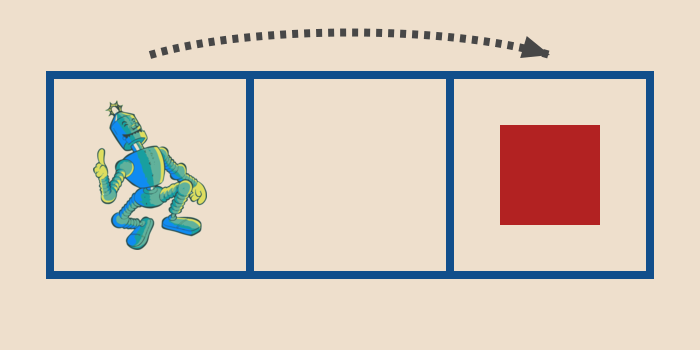

In [7]:
draw_scene(scene, true)

In [24]:
function mh_inference(model, args, obs, iter)
    objects = [(:object, s.object) for s in first(args)]
    (trace, _) = Gen.generate(model, args, obs)
    traces = Array{typeof(trace)}(undef, iter)
    traces[1] = trace
    for i = 2:iter
        (traces[i], _) = mh(traces[i-1], select(objects...))
    end
    return traces
end

function do_inference(model, scenes, observations, amount_of_compute)
    n_observations = size(observations, 1)
    obs = Gen.choicemap()
    for i=1:n_observations
        obs[(:moved, i)] = observations[i]
    end
    # (trace, _) = Gen.importance_resampling(model, (scenes,), obs, amount_of_compute);
    traces = mh_inference(model, (scenes,), obs, amount_of_compute)
    return traces
end;

In [51]:
#scenes = [scene]
#observations = [true]
scenes = [scene, Scene(:square, true)];
observations = [true, true];

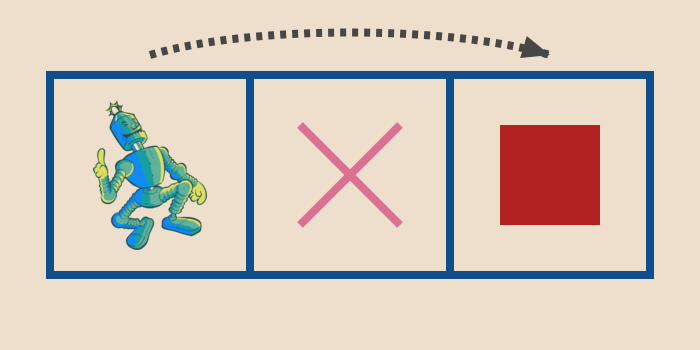

In [54]:
for i=1:size(scenes, 1)
    draw_blank()
    sleep(0.5)
    draw_scene(scenes[i], observations[i])
    sleep(3)
end

In [55]:
traces = [last(do_inference(generative_model, scenes, observations, 1000)) for _=1:1000];
traces = vcat(traces...)
belief_square = Vector{Float64}(undef, size(traces, 1))

for i = 1:size(belief_square,1)
    belief_square[i] = traces[i][(:object, :square)]
end

println(sum(belief_square) / size(traces, 1))
println(belief_square)

1.99
[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0,

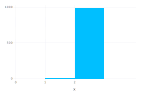

In [56]:
plot(x = belief_square, Geom.histogram(), Guide.xticks(ticks = [0.0, 1.0, 2.0]))
    #Gadfly.Scale.x_continuous(minvalue = 0, maxvalue =2))

In [ ]:
#########################

### Exercise

Constrain the start and destination points to two particular locations in the scene, and visualize the distribution on paths. Find a start point and destination point such that the distributions on paths is multimodal (i.e. there are two spatially separated paths that the agent may take). Describe the variability in the planned paths.

### Solution



We now write a simple algorithm for inferring the destination of an agent given (i) the scene, (ii) the start location of the agent, and (iii) a sequence of measured locations of the agent for each tick.

We will assume the agent starts in the lower left-hand corner.

In [ ]:
start = Point(0.1, 0.1);

We will infer the destination of the agent for the given sequence of observed locations:

In [ ]:
measurements = [
    Point(0.0980245, 0.104775),
    Point(0.113734, 0.150773),
    Point(0.100412, 0.195499),
    Point(0.114794, 0.237386),
    Point(0.0957668, 0.277711),
    Point(0.140181, 0.31304),
    Point(0.124384, 0.356242),
    Point(0.122272, 0.414463),
    Point(0.124597, 0.462056),
    Point(0.126227, 0.498338)];

We visualize this data set on top of the scene:

In [ ]:
info = Dict("start" => start, "scene" => scene, "measurements" => measurements)
viz = Viz(viz_server, joinpath(@__DIR__, "../inverse-planning/overlay-viz/dist"), info)
displayInNotebook(viz)

Next, we write a simple inference program for this task:

In [ ]:
function do_inference_agent_model(scene::Scene, dt::Float64, num_ticks::Int, planner_params::PlannerParams, start::Point,
                                  measurements::Vector{Point}, amount_of_computation::Int)
    
    # Create an "Assignment" that maps model addresses (:y, i)
    # to observed values ys[i]. We leave :slope and :intercept
    # unconstrained, because we want them to be inferred.
    observations = Gen.choicemap()
    observations[:start_x] = start.x
    observations[:start_y] = start.y
    for (i, m) in enumerate(measurements)
        observations[:meas => (i, :x)] = m.x
        observations[:meas => (i, :y)] = m.y
    end
    
    # Call importance_resampling to obtain a likely trace consistent
    # with our observations.
    (trace, _) = Gen.importance_resampling(agent_model, (scene, dt, num_ticks, planner_params), observations, amount_of_computation)
    
    return trace
end;

Below, we run this algorithm 1000 times, to generate 1000 approximate samples from the posterior distribution on the destination. The inferred destinations should appear as red dots on the map.

In [ ]:
info = Dict("measurements" => measurements, "scene" => scene, "start" => start)
viz = Viz(viz_server, joinpath(@__DIR__, "../inverse-planning/overlay-viz/dist"), info)
openInNotebook(viz)
sleep(5)
for i=1:1000
    trace = do_inference_agent_model(scene, dt, num_ticks, planner_params, start, measurements, 50)
    putTrace!(viz, i, trace_to_dict(trace))
end
displayInNotebook(viz)

### Exercise
The first argument to `PlannerParams` is the number of iterations of the RRT algorithm to use. The third argument to `PlannerParams` is the number of iterations of path refinement. These parameters affect the distribution on paths of the agent. Visualize traces of the `agent_model` for with a couple different settings of these two parameters to the path planning algorithm for fixed starting point and destination point. Try setting them to smaller values. Discuss.

### Solution

We have provided starter code.

In [ ]:
constraints = Gen.choicemap()
constraints[:start_x] = 0.1
constraints[:start_y] = 0.1;

Modify the `PlannerParams` in the two cells below.

In [ ]:
planner_params = PlannerParams(300, 3.0, 2000, 1.) # < change this line>

viz = Viz(viz_server, joinpath(@__DIR__, "../inverse-planning/grid-viz/dist"), [])
for i=1:12
    (trace, _) = Gen.generate(agent_model, (scene, dt, num_ticks, planner_params), constraints)
    putTrace!(viz, i, trace_to_dict(trace))
end
displayInNotebook(viz)

In [ ]:
planner_params = PlannerParams(300, 3.0, 2000, 1.) # < change this line>

viz = Viz(viz_server, joinpath(@__DIR__, "../inverse-planning/grid-viz/dist"), [])
for i=1:12
    (trace, _) = Gen.generate(agent_model, (scene, dt, num_ticks, planner_params), constraints)
    putTrace!(viz, i, trace_to_dict(trace))
end
displayInNotebook(viz)